# Coursera Capstone Project – The Battle of Neighborhoods 

##### Introduction: 
New England cuisine is an American cuisine which originated in the New England region of the United States, and traces its roots to English cuisine. It is characterized by extensive use of seafood and dairy products, which results from its historical reliance on its seaports and fishing industry, as well as extensive dairy farming in inland regions. Many of New England's earliest Puritan settlers were from eastern England, where baking foods was more common than frying, such as pies, beans, and turkey, as was the tradition elsewhere.

Two prominent characteristic foodstuffs native to New England are maple syrup and cranberries. The traditional standard starch is potato, though rice has a somewhat increased popularity in modern cooking. New England cuisine is known for limited use of spices aside from ground black pepper, although parsley, garlic, and sage are common, with a few Caribbean additions such as nutmeg. Use of cream is common, due to the reliance on dairy. The favored cooking techniques are stewing, steaming, and baking. Many local ingredients, such as squash, corn and local beans, sunflowers, wild turkey, maple syrup, cranberries and dishes such as cornbread, Johnnycakes and Indian pudding were adopted from Southern New England Algonquian cuisine.


##### 2)Data
The necessary information needed by the investing group will come from the following sources:

##### Geographic boundaries of Connecticut - For providing an overview of the neighbourhood in Connecticut
http://www.connquest.com/ct/zipcodes.html

##### Wikipedia - about the list of neighborhoods in Connecticut:
https://www.zipcodestogo.com/Connecticut/

https://www.unitedstateszipcodes.org/ct/ 
Open dataset to provide the latitude and longitude of the neighbourhoods in the Connecticut.

Foursquare API to collect information on other venues/competitors in the neighborhoods of Connecticut

##### Approach:
•         Collect the Connecticut data with county details
•         Using Foursquare API we will find all venues for each neighborhood.
•         Filter out all venues that don’t have Indian Restaurants.
•         Find out the counties in Connecticut which don’t have Indian Restaurant using Foursquare API.
•         List out the results and counties 
          Visualize the neighborhoods using folium library(python)


##### Questions that can be asked using the above mentioned datasets:
•         What counties can be chosen to open a Indian cuisine restaurant?


### Data collection and preparation for analysis

##### Importing all the required libraries for the analysis

In [2]:
import os
import numpy as np
import pandas as pd
import requests # library to handle requests
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

!pip install geopy
!pip install folium
!pip install xlrd

print('Required Libraries are imported')

Required Libraries are imported


##### Reading the excel sheet for data of Connecticut state

In [30]:
df_ct = pd.read_excel("D:/Dataset-CT.xlsx")
df_ct['Zipcode']='0'+ df_ct['Zipcode'].astype(str)
#df_ct = df_ct[df_ct['County']=='Hartford']
df_ct

,Zipcode,City,County
0,06001,Avon,Hartford
1,06002,Bloomfield,Hartford
2,06006,Windsor,Hartford
3,06010,Bristol,Hartford
4,06011,Bristol,Hartford
...,...,...,...
433,06922,Stamford,Fairfield
434,06925,Stamford,Fairfield
435,06926,Stamford,Fairfield
436,06927,Stamford,Fairfield


In [31]:
df_latlon = pd.read_excel("D:/Dataset-LatLon.xlsx")
df_latlon['Zip']='0'+ df_latlon['Zip'].astype(str)
df_latlon = df_latlon.rename(columns={"Zip": "Zipcode"})
df_latlon

,Zipcode,City,Latitude,Longitude
0,06053,New Britain,41.686949,-72.790800
1,06410,Cheshire,41.507049,-72.904890
2,06074,South Windsor,41.836665,-72.560760
3,06520,New Haven,41.365709,-72.927507
4,06513,New Haven,41.315797,-72.880300
...,...,...,...,...
438,06146,Hartford,41.791776,-72.718832
439,06243,East Killingly,41.844885,-71.818941
440,06360,Norwich,41.533848,-72.062320
441,06514,Hamden,41.357947,-72.937650


In [32]:
df_ct_new = pd.merge(df_ct,df_latlon,left_on=['Zipcode'],right_on=['Zipcode'],how='left')
df_ct_new = df_ct_new.rename(columns={"City_x": "City"})
df_ct_new = df_ct_new.drop(columns=['City_y'])
df_ct_new

,Zipcode,City,County,Latitude,Longitude
0,06001,Avon,Hartford,41.789698,-72.864310
1,06002,Bloomfield,Hartford,41.832798,-72.726420
2,06006,Windsor,Hartford,41.879637,-72.734271
3,06010,Bristol,Hartford,41.682249,-72.933650
4,06011,Bristol,Hartford,41.791776,-72.718832
...,...,...,...,...,...
433,06922,Stamford,Fairfield,41.051551,-73.514344
434,06925,Stamford,Fairfield,41.308873,-73.363661
435,06926,Stamford,Fairfield,41.041197,-73.538567
436,06927,Stamford,Fairfield,41.308873,-73.363661


In [33]:
df_ct_new.shape

(438, 5)

In [34]:
df_ct_new = df_ct_new.dropna()
df_ct_new.shape

(431, 5)

In [35]:
from geopy.geocoders import Nominatim

address = 'Connecticut'

geolocator = Nominatim(user_agent="ct_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Connecticut are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Connecticut are 41.6500201, -72.7342163.


In [36]:
import folium
print(folium.__version__)
map_connect = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_ct_new['Latitude'], df_ct_new['Longitude'], df_ct_new['City']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_connect)  
    
map_connect

0.10.1


##### We define a function to intract with FourSquare API and get top 100 venues within a radius of 500 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [37]:
def get_venues(lat,lng):
    
    #set variables
    radius=500
    LIMIT=100
    CLIENT_ID = '1RITNDNUVVRHUDTJDOWT2ZNSB4EOAEKQBERI2HRW2VQKSDBH' # Foursquare ID
    CLIENT_SECRET = 'ZZWAZHH0RSAEMDYZCNYDCIPD2HGFVROSQAR3SBQTG2OJNCJF' # Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

###### Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [38]:
df_ct_new.shape

(431, 5)

#####  so there are 431 different neighbourhoods in connecticut

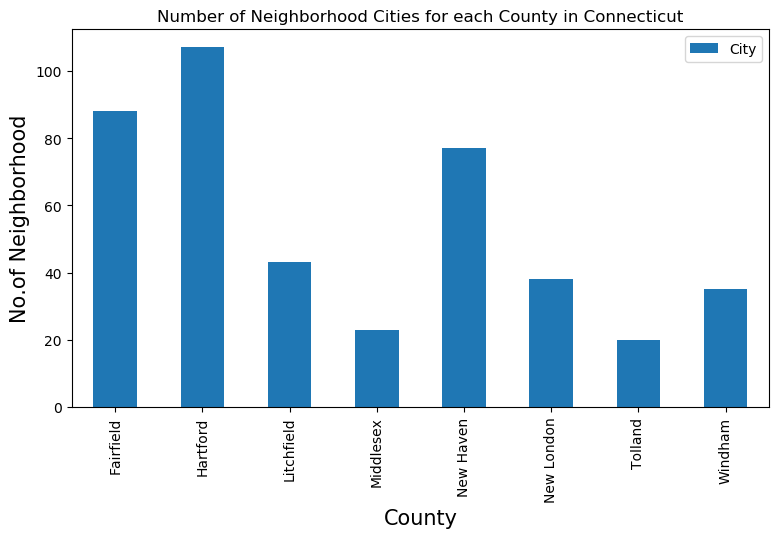

In [39]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood Cities for each County in Connecticut')
#On x-axis
plt.xlabel('County', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
df_ct_new.groupby('County')['City'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

###### We see that Hartford county has many number of cities in CT

In [27]:
df_ct_new.head()

,Zipcode,City,County,Latitude,Longitude
0,06001,Avon,Hartford,41.789698,-72.864310
1,06002,Bloomfield,Hartford,41.832798,-72.726420
2,06006,Windsor,Hartford,41.879637,-72.734271
3,06010,Bristol,Hartford,41.682249,-72.933650
4,06011,Bristol,Hartford,41.791776,-72.718832


In [40]:
df_ct_new.shape

(431, 5)

In [41]:
# prepare neighborhood list that contains indian resturants
column_names=['Zipcode', 'City','County', 'Id','Name']
rest_ct=pd.DataFrame(columns=column_names)
count=1
for row in df_ct_new.values.tolist():
    Zipcode, City,County, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(df_ct_new),')','Indian Restaurants in '+City+', '+County+':'+str(len(resturants)))
    for resturant_detail in resturants.values.tolist():
        id, name , category=resturant_detail
        rest_ct = rest_ct.append({'Zipcode': Zipcode,'City':City,
                                                'County': County, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 431 ) Indian Restaurants in Avon, Hartford:0
( 2 / 431 ) Indian Restaurants in Bloomfield, Hartford:0
( 3 / 431 ) Indian Restaurants in Windsor, Hartford:0
( 4 / 431 ) Indian Restaurants in Bristol, Hartford:0
( 5 / 431 ) Indian Restaurants in Bristol, Hartford:0
( 6 / 431 ) Indian Restaurants in Burlington, Hartford:0
( 7 / 431 ) Indian Restaurants in Broad Brook, Hartford:0
( 8 / 431 ) Indian Restaurants in Canaan, Litchfield:0
( 9 / 431 ) Indian Restaurants in Canton, Hartford:0
( 10 / 431 ) Indian Restaurants in Canton Center, Hartford:0
( 11 / 431 ) Indian Restaurants in Colebrook, Litchfield:0
( 12 / 431 ) Indian Restaurants in Collinsville, Hartford:0
( 13 / 431 ) Indian Restaurants in East Berlin, Hartford:0
( 14 / 431 ) Indian Restaurants in East Canaan, Litchfield:0
( 15 / 431 ) Indian Restaurants in East Glastonbury, Hartford:0
( 16 / 431 ) Indian Restaurants in East Granby, Hartford:0
( 17 / 431 ) Indian Restaurants in East Hartland, Hartford:0
( 18 / 431 ) Indian Res

( 143 / 431 ) Indian Restaurants in Hampton, Windham:0
( 144 / 431 ) Indian Restaurants in Hebron, Tolland:0
( 145 / 431 ) Indian Restaurants in Lebanon, New London:0
( 146 / 431 ) Indian Restaurants in Mansfield Center, Tolland:0
( 147 / 431 ) Indian Restaurants in Mansfield Depot, Tolland:0
( 148 / 431 ) Indian Restaurants in North Franklin, New London:0
( 149 / 431 ) Indian Restaurants in North Grosvenordale, Windham:0
( 150 / 431 ) Indian Restaurants in North Windham, Windham:0
( 151 / 431 ) Indian Restaurants in Pomfret, Windham:0
( 152 / 431 ) Indian Restaurants in Pomfret Center, Windham:0
( 153 / 431 ) Indian Restaurants in Putnam, Windham:0
( 154 / 431 ) Indian Restaurants in Quinebaug, Windham:0
( 155 / 431 ) Indian Restaurants in Rogers, Windham:0
( 156 / 431 ) Indian Restaurants in Scotland, Windham:0
( 157 / 431 ) Indian Restaurants in South Willington, Tolland:0
( 158 / 431 ) Indian Restaurants in South Windham, Windham:0
( 159 / 431 ) Indian Restaurants in South Woodstoc

( 282 / 431 ) Indian Restaurants in East Haven, New Haven:0
( 283 / 431 ) Indian Restaurants in New Haven, New Haven:0
( 284 / 431 ) Indian Restaurants in Hamden, New Haven:0
( 285 / 431 ) Indian Restaurants in New Haven, New Haven:0
( 286 / 431 ) Indian Restaurants in West Haven, New Haven:1
( 287 / 431 ) Indian Restaurants in Hamden, New Haven:0
( 288 / 431 ) Indian Restaurants in Hamden, New Haven:0
( 289 / 431 ) Indian Restaurants in New Haven, New Haven:0
( 290 / 431 ) Indian Restaurants in New Haven, New Haven:0
( 291 / 431 ) Indian Restaurants in New Haven, New Haven:0
( 292 / 431 ) Indian Restaurants in Bethany, New Haven:0
( 293 / 431 ) Indian Restaurants in Woodbridge, New Haven:0
( 294 / 431 ) Indian Restaurants in New Haven, New Haven:0
( 295 / 431 ) Indian Restaurants in New Haven, New Haven:0
( 296 / 431 ) Indian Restaurants in New Haven, New Haven:0
( 297 / 431 ) Indian Restaurants in New Haven, New Haven:0
( 298 / 431 ) Indian Restaurants in New Haven, New Haven:0
( 299

( 421 / 431 ) Indian Restaurants in Stamford, Fairfield:0
( 422 / 431 ) Indian Restaurants in Stamford, Fairfield:0
( 423 / 431 ) Indian Restaurants in Stamford, Fairfield:0
( 424 / 431 ) Indian Restaurants in Stamford, Fairfield:0
( 425 / 431 ) Indian Restaurants in Stamford, Fairfield:0
( 426 / 431 ) Indian Restaurants in Stamford, Fairfield:2
( 427 / 431 ) Indian Restaurants in Stamford, Fairfield:0
( 428 / 431 ) Indian Restaurants in Stamford, Fairfield:0
( 429 / 431 ) Indian Restaurants in Stamford, Fairfield:0
( 430 / 431 ) Indian Restaurants in Stamford, Fairfield:0
( 431 / 431 ) Indian Restaurants in Stamford, Fairfield:0


In [42]:
rest_ct.head()

,Zipcode,City,County,Id,Name,ID
0,06110,West Hartford,Hartford,NaN,Mount Everest Spice,5782869d498e8d809ac0b23a
1,06115,Hartford,Hartford,NaN,Royal Masala Restaurant & Bar,4b5b77fbf964a520890029e3
2,06183,Hartford,Hartford,NaN,Royal Masala Restaurant & Bar,4b5b77fbf964a520890029e3
3,06268,Storrs Mansfield,Tolland,NaN,Wing Express,4bb8bd7d314e95212cb2489d
4,06510,New Haven,New Haven,NaN,Tikkaway Grill,5207cbac11d263e52f2eb781


In [43]:
rest_ct.shape

(16, 6)

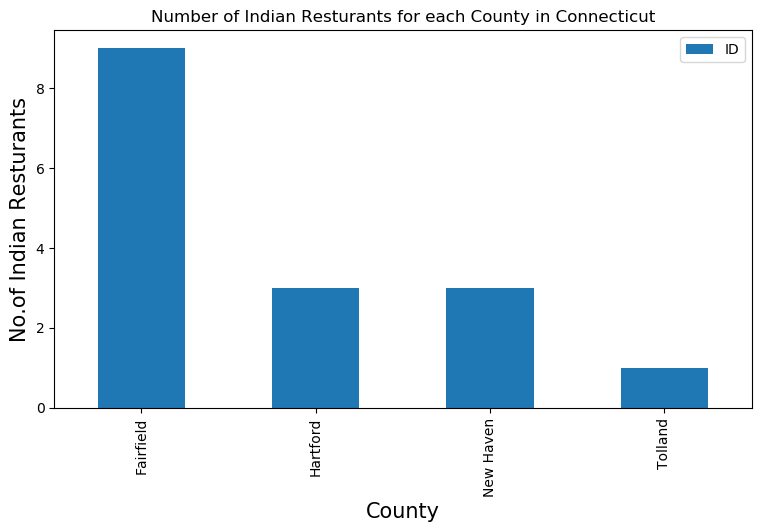

In [44]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each County in Connecticut')
#On x-axis
plt.xlabel('County', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
rest_ct.groupby('County')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

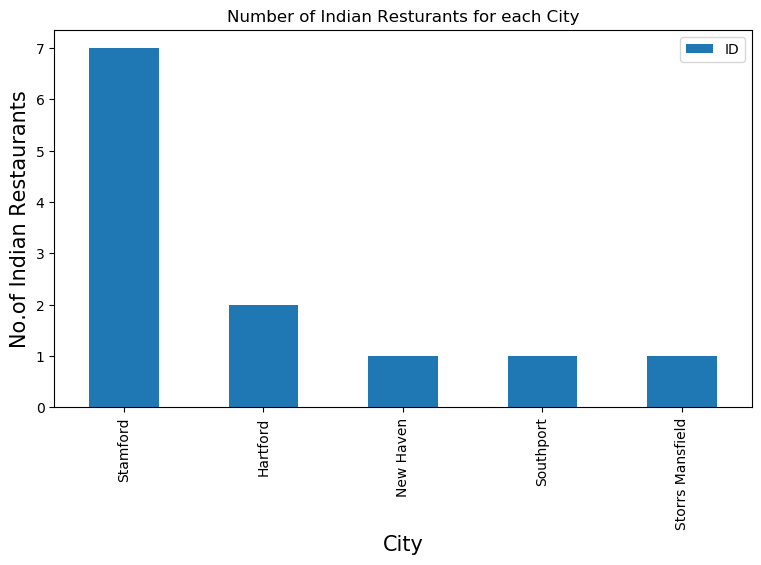

In [45]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each City')
#On x-axis
plt.xlabel('City', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
rest_ct.groupby('City')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

###### So Stamford in Fairfield county has the largest number of Indian restaurants with the total count of 7

In [46]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '1RITNDNUVVRHUDTJDOWT2ZNSB4EOAEKQBERI2HRW2VQKSDBH' # Foursquare ID
    CLIENT_SECRET = 'ZZWAZHH0RSAEMDYZCNYDCIPD2HGFVROSQAR3SBQTG2OJNCJF' # Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [50]:
rest_ct

,Zipcode,City,County,Name,ID
0,06110,West Hartford,Hartford,Mount Everest Spice,5782869d498e8d809ac0b23a
1,06115,Hartford,Hartford,Royal Masala Restaurant & Bar,4b5b77fbf964a520890029e3
2,06183,Hartford,Hartford,Royal Masala Restaurant & Bar,4b5b77fbf964a520890029e3
3,06268,Storrs Mansfield,Tolland,Wing Express,4bb8bd7d314e95212cb2489d
4,06510,New Haven,New Haven,Tikkaway Grill,5207cbac11d263e52f2eb781
5,06516,West Haven,New Haven,Chaat House,4f32475819836c91c7c7f6b9
6,06708,Waterbury,New Haven,Muyuri Indian Bistro,5a6927c1a423627235c97581
7,06889,Westport,Fairfield,The Mumbai Times,4d39e32917312c0fc97029f2
8,06890,Southport,Fairfield,Coromandel Cuisine of India,4cfaf26520fe370417fe50f8
9,06901,Stamford,Fairfield,Navaratna,4bbd01d3593fef3b11ef0256


In [52]:
column_names=['Zipcode','City','County', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ct=pd.DataFrame(columns=column_names)
count=1

for row in rest_ct.values.tolist():
    Zipcode,City,County,Name,ID=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(rest_ct),')','processed')
    indian_rest_stats_ct = indian_rest_stats_ct.append({'Zipcode': Zipcode,
                                                'City': City, 
                                                'County': County,
                                                'ID': ID,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 5782869d498e8d809ac0b23a
( 1 / 16 ) processed
                         ID                           Name  Likes  Rating  \
0  4b5b77fbf964a520890029e3  Royal Masala Restaurant & Bar     10     6.6   

   Tips  
0     8  
( 2 / 16 ) processed
                         ID                           Name  Likes  Rating  \
0  4b5b77fbf964a520890029e3  Royal Masala Restaurant & Bar     10     6.6   

   Tips  
0     8  
( 3 / 16 ) processed
                         ID          Name  Likes  Rating  Tips
0  4bb8bd7d314e95212cb2489d  Wing Express      4     6.1     5
( 4 / 16 ) processed
                         ID            Name  Likes  Rating  Tips
0  5207cbac11d263e52f2eb781  Tikkaway Grill     67     8.5    17
( 5 / 16 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4f32475819836c91c7c7f6b9
( 6 / 16 ) processed
Empty DataFrame
Columns: [ID, Na

In [53]:
indian_rest_stats_ct

,Zipcode,City,County,ID,Name,Likes,Rating,Tips
0,06110,West Hartford,Hartford,5782869d498e8d809ac0b23a,0,0,0,0
1,06115,Hartford,Hartford,4b5b77fbf964a520890029e3,Royal Masala Restaurant & Bar,10,6.6,8
2,06183,Hartford,Hartford,4b5b77fbf964a520890029e3,Royal Masala Restaurant & Bar,10,6.6,8
3,06268,Storrs Mansfield,Tolland,4bb8bd7d314e95212cb2489d,Wing Express,4,6.1,5
4,06510,New Haven,New Haven,5207cbac11d263e52f2eb781,Tikkaway Grill,67,8.5,17
5,06516,West Haven,New Haven,4f32475819836c91c7c7f6b9,0,0,0,0
6,06708,Waterbury,New Haven,5a6927c1a423627235c97581,0,0,0,0
7,06889,Westport,Fairfield,4d39e32917312c0fc97029f2,The Mumbai Times,8,7.7,6
8,06890,Southport,Fairfield,4cfaf26520fe370417fe50f8,Coromandel Cuisine of India,18,8,7
9,06901,Stamford,Fairfield,4bbd01d3593fef3b11ef0256,Navaratna,18,8,18


###### Conclusion:
Middlesex and Tolland counties are least in the Indian restaurant
Fairfield and Hartford counties are the toppest among having the indian restaurant
Tikkaway Grill and coromandel cuisine of india restaurants has the highest number of likes

So Middlesex and Tolland counties are best to open a Indian cuisine restaurant